In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

In [5]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/tomato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 551M/551M [00:06<00:00, 94.9MB/s]


In [6]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/train",
    label_mode="categorical",
    class_names= ['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/valid",
    label_mode="categorical",
    class_names= ['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 17195 files belonging to 9 classes.
==========================Validation Data====================
Found 4197 files belonging to 9 classes.


In [11]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("tomato/Tomato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("tomato/Tomato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 17195 images belonging to 9 classes.
Found 4197 images belonging to 9 classes.


In [12]:
# Check GPU
!nvidia-smi

Sun Jun  4 14:40:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

In [15]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Tomato_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [16]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                           

In [17]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.8441
Epoch 1: val_accuracy improved from -inf to 0.24970, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 178s 152ms/step - loss: 0.5515 - accuracy: 0.8441 - val_loss: 5.0882 - val_accuracy: 0.2497 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.9222
Epoch 2: val_accuracy improved from 0.24970 to 0.57708, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 125s 145ms/step - loss: 0.2512 - accuracy: 0.9222 - val_loss: 1.8728 - val_accuracy: 0.5771 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9357
Epoch 3: val_accuracy did not improve from 0.57708
860/860 [==============================] - 101s 117ms/step - loss: 0.2033 - accuracy: 0.9357 - val_loss: 2.0114 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9412
Epoch 4: val_accuracy did not improve from 0.57708
860/860 [==============================] - 101s 117ms/step - loss: 0.1885 - accuracy: 0.9412 - val_loss: 2.2208 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9357
Epoch 5: val_accuracy improved from 0.57708 to 0.62878, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 124s 145ms/step - loss: 0.2043 - accuracy: 0.9357 - val_loss: 1.2332 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 6/100
860/860 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9412
Epoch 6: val_accuracy did not improve from 0.62878
860/860 [==============================] - 100s 117ms/step - loss: 0.1816 - accuracy: 0.9412 - val_loss: 1.3274 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 7/100
860/860 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9457
Epoch 7: val_accuracy did not improve from 0.62878
860/860 [==============================] - 100s 116ms/step - loss: 0.1723 - accuracy: 0.9457 - val_loss: 3.0244 - val_accuracy: 0.4051 - lr: 0.0010
Epoch 8/100
860/860 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9485
Epoch 8: val_accuracy improved from 0.62878 to 0.89207, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 124s 144ms/step - loss: 0.1639 - accuracy: 0.9485 - val_loss: 0.3649 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 9/100
860/860 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9539
Epoch 9: val_accuracy did not improve from 0.89207
860/860 [==============================] - 100s 116ms/step - loss: 0.1450 - accuracy: 0.9539 - val_loss: 2.2238 - val_accuracy: 0.4680 - lr: 0.0010
Epoch 10/100
860/860 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9542
Epoch 10: val_accuracy did not improve from 0.89207
860/860 [==============================] - 100s 116ms/step - loss: 0.1452 - accuracy: 0.9542 - val_loss: 0.5137 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 11/100
860/860 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9540
Epoch 11: val_accuracy did not improve from 0.89207
860/860 [==============================] - 100s 116ms/step - loss: 0.1430 - accuracy: 0.9540 - val_loss: 0.6

860/860 [==============================] - 123s 143ms/step - loss: 0.0657 - accuracy: 0.9782 - val_loss: 0.0510 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9830
Epoch 15: val_accuracy improved from 0.98332 to 0.98737, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 124s 145ms/step - loss: 0.0461 - accuracy: 0.9830 - val_loss: 0.0427 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9862
Epoch 16: val_accuracy improved from 0.98737 to 0.98832, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 134s 156ms/step - loss: 0.0371 - accuracy: 0.9862 - val_loss: 0.0409 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9884
Epoch 17: val_accuracy did not improve from 0.98832
860/860 [==============================] - 103s 120ms/step - loss: 0.0322 - accuracy: 0.9884 - val_loss: 0.0414 - val_accuracy: 0.9876 - lr: 1.0000e-04
Epoch 18/100
860/860 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9896
Epoch 18: val_accuracy improved from 0.98832 to 0.98880, saving model to Tomato_MobileNetV2_model1_Based_Non_Augmented


860/860 [==============================] - 136s 159ms/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.0344 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9905
Epoch 19: val_accuracy did not improve from 0.98880
860/860 [==============================] - 103s 119ms/step - loss: 0.0263 - accuracy: 0.9905 - val_loss: 0.0474 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9925
Epoch 20: val_accuracy did not improve from 0.98880
860/860 [==============================] - 103s 119ms/step - loss: 0.0204 - accuracy: 0.9925 - val_loss: 0.0497 - val_accuracy: 0.9859 - lr: 1.0000e-04
Epoch 21/100
860/860 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9928
Epoch 21: val_accuracy did not improve from 0.98880
860/860 [==============================] - 110s 128ms/step - loss: 0.0190 - accuracy: 0.9928 -

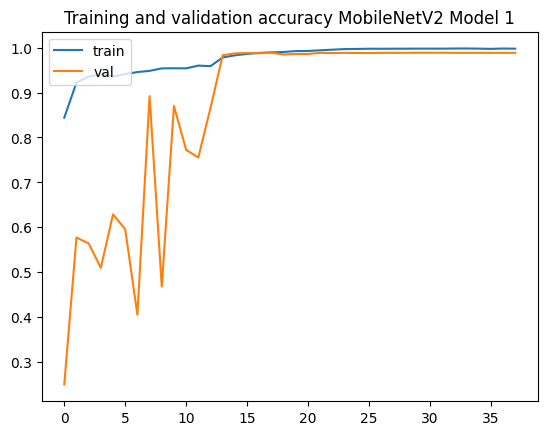

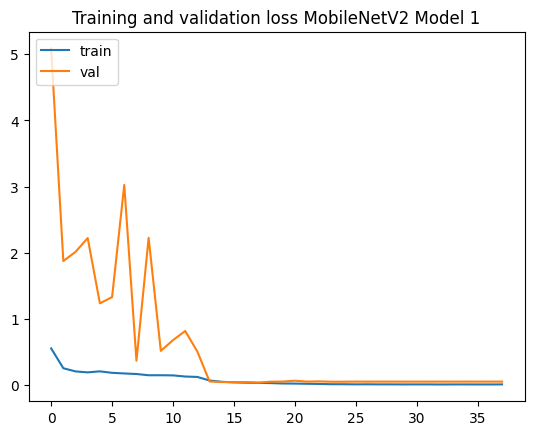

In [18]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [19]:
!zip -r /content/Tomato_MobileNetV2_model1_Based_Non_Augmented.zip /content/Tomato_MobileNetV2_model1_Based_Non_Augmented

  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/variables/variables.index (deflated 77%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model1_Based_Non_Augmented/saved_model.pb (deflated 91%)


In [20]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Tomato_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [22]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 2,588,233
Trainable params: 2,554,121
No

In [23]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8543
Epoch 1: val_accuracy improved from -inf to 0.43126, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 164s 158ms/step - loss: 0.4599 - accuracy: 0.8543 - val_loss: 4.2358 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9245
Epoch 2: val_accuracy improved from 0.43126 to 0.46414, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 123s 143ms/step - loss: 0.2394 - accuracy: 0.9245 - val_loss: 3.4166 - val_accuracy: 0.4641 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9381
Epoch 3: val_accuracy did not improve from 0.46414
860/860 [==============================] - 100s 116ms/step - loss: 0.1953 - accuracy: 0.9381 - val_loss: 4.9929 - val_accuracy: 0.4627 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9435
Epoch 4: val_accuracy improved from 0.46414 to 0.73338, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 123s 144ms/step - loss: 0.1749 - accuracy: 0.9435 - val_loss: 1.3918 - val_accuracy: 0.7334 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9481
Epoch 5: val_accuracy improved from 0.73338 to 0.87229, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 124s 144ms/step - loss: 0.1606 - accuracy: 0.9481 - val_loss: 0.6218 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 6/100
860/860 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9513
Epoch 6: val_accuracy did not improve from 0.87229
860/860 [==============================] - 100s 116ms/step - loss: 0.1504 - accuracy: 0.9513 - val_loss: 1.6310 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 7/100
860/860 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9580
Epoch 7: val_accuracy did not improve from 0.87229
860/860 [==============================] - 100s 116ms/step - loss: 0.1282 - accuracy: 0.9580 - val_loss: 1.9200 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 8/100
860/860 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9566
Epoch 8: val_accuracy did not improve from 0.87229
860/860 [==============================] - 100s 116ms/step - loss: 0.1349 - accuracy: 0.9566 - val_loss: 2.7066 

860/860 [==============================] - 124s 145ms/step - loss: 0.0618 - accuracy: 0.9780 - val_loss: 0.0826 - val_accuracy: 0.9774 - lr: 1.0000e-04
Epoch 12/100
860/860 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9828
Epoch 12: val_accuracy improved from 0.97736 to 0.98737, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 124s 144ms/step - loss: 0.0452 - accuracy: 0.9828 - val_loss: 0.0399 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 13/100
860/860 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9846
Epoch 13: val_accuracy improved from 0.98737 to 0.98904, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 124s 144ms/step - loss: 0.0407 - accuracy: 0.9846 - val_loss: 0.0334 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 14/100
860/860 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9869
Epoch 14: val_accuracy improved from 0.98904 to 0.98928, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 123s 144ms/step - loss: 0.0337 - accuracy: 0.9869 - val_loss: 0.0372 - val_accuracy: 0.9893 - lr: 1.0000e-04
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9878
Epoch 15: val_accuracy did not improve from 0.98928
860/860 [==============================] - 100s 116ms/step - loss: 0.0318 - accuracy: 0.9878 - val_loss: 0.0379 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9905
Epoch 16: val_accuracy did not improve from 0.98928
860/860 [==============================] - 99s 115ms/step - loss: 0.0262 - accuracy: 0.9905 - val_loss: 0.0505 - val_accuracy: 0.9845 - lr: 1.0000e-04
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9921
Epoch 17: val_accuracy improved from 0.98928 to 0.98975, saving model to Tomato_MobileNetV2_model2_Based_Non_Augmented


860/860 [==============================] - 124s 144ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 0.0409 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 18/100
860/860 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9933
Epoch 18: val_accuracy did not improve from 0.98975

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
860/860 [==============================] - 100s 116ms/step - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.0469 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9946
Epoch 19: val_accuracy did not improve from 0.98975
860/860 [==============================] - 100s 117ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0414 - val_accuracy: 0.9898 - lr: 1.0000e-05
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9956
Epoch 20: val_accuracy did not improve from 0.98975
860/860 [======

860/860 [==============================] - 124s 144ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0418 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 22/100
860/860 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9960
Epoch 22: val_accuracy did not improve from 0.99047
860/860 [==============================] - 100s 117ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0421 - val_accuracy: 0.9893 - lr: 1.0000e-05
Epoch 23/100
860/860 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9963
Epoch 23: val_accuracy did not improve from 0.99047

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
860/860 [==============================] - 101s 117ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0428 - val_accuracy: 0.9895 - lr: 1.0000e-05
Epoch 24/100
860/860 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9966
Epoch 24: val_accuracy did not improve from 0.99047
860/860 [======

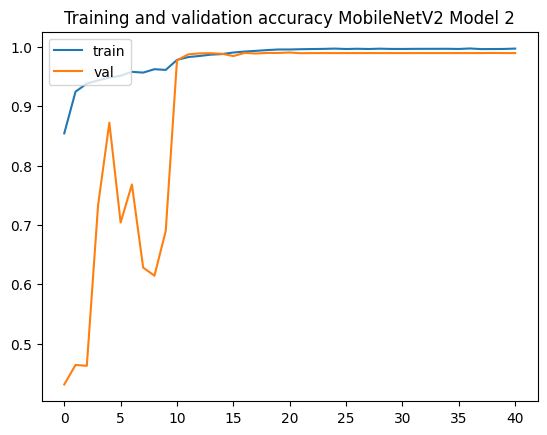

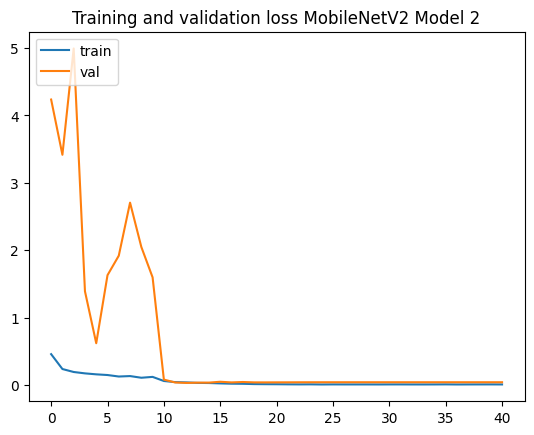

In [24]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [25]:
!zip -r /content/Tomato_MobileNetV2_model2_Based_Non_Augmented.zip /content/Tomato_MobileNetV2_model2_Based_Non_Augmented

  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/variables/variables.index (deflated 77%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Tomato_MobileNetV2_model2_Based_Non_Augmented/saved_model.pb (deflated 91%)
